## **IMAGE SEGMENTATION USING THE COCO-2017 DATASET**

The **MS COCO (Microsoft Common Objects in Context) dataset** is a large-scale object detection, segmentation, key-point detection, and captioning dataset.
**Image segmentation** is a computer vision technique that partitions a digital image into discrete groups of pixels—image segments—to inform object detection and related tasks. By parsing an image's complex visual data into specifically shaped segments, image segmentation enables faster, more advanced image processing.

# **Importing Necessary Libraries and Setting up COCO 2017 Dataset from Drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os

# Load labels
with open('/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/labels.json') as f:
    train_labels = json.load(f)

with open('/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/labels.json') as f:
    val_labels = json.load(f)

# Example structure inspection
print(json.dumps(train_labels['annotations'][:5], indent=2))  # Display the first 5 annotations


[
  {
    "id": 1,
    "image_id": 1,
    "category_id": 41,
    "bbox": [
      388.03,
      324.65,
      9.61,
      13.33
    ],
    "segmentation": [
      [
        392.0,
        335.5,
        388.0,
        323.5,
        393.0,
        323.5,
        392.5,
        328.0,
        395.5,
        330.0,
        395.5,
        334.0,
        392.0,
        335.5
      ]
    ],
    "area": 128.10129999999998,
    "iscrowd": 0,
    "supercategory": "person"
  },
  {
    "id": 2,
    "image_id": 1,
    "category_id": 41,
    "bbox": [
      339.42,
      316.81,
      6.879999999999999,
      13.08
    ],
    "segmentation": [
      [
        344.0,
        328.5,
        340.5,
        327.0,
        338.5,
        320.0,
        342.0,
        315.5,
        345.5,
        317.0,
        344.0,
        328.5
      ]
    ],
    "area": 89.9904,
    "iscrowd": 0,
    "supercategory": "person"
  },
  {
    "id": 3,
    "image_id": 1,
    "category_id": 41,
    "bbox": [
      333.2

# **Exploratory Data Analysis (EDA)**

Class Distribution Analysis
Identify the four classes of interest: cake, car, dog, and person. This helps to analyze class distributions in training and validation sets.

In [ ]:
import json
train_data_dir = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data'
train_json_path = os.path.join(train_data_dir, 'labels.json')
# Path to the COCO 2017 annotations file


# Load the annotations
with open(train_json_path, 'r') as f:
    data = json.load(f)

# Create a mapping from category name to ID
category_mapping = {category['name']: category['id'] for category in data['categories']}

# Retrieve IDs for 'dog' and 'cake'
dog_id = category_mapping.get('dog')
cake_id = category_mapping.get('cake')
person_id = category_mapping.get('person')
car_id = category_mapping.get('car')


print(f"Dog Category ID: {dog_id}")
print(f"Cake Category ID: {cake_id}")
print(f"Person Category ID: {person_id}")
print(f"Car Category ID: {car_id}")

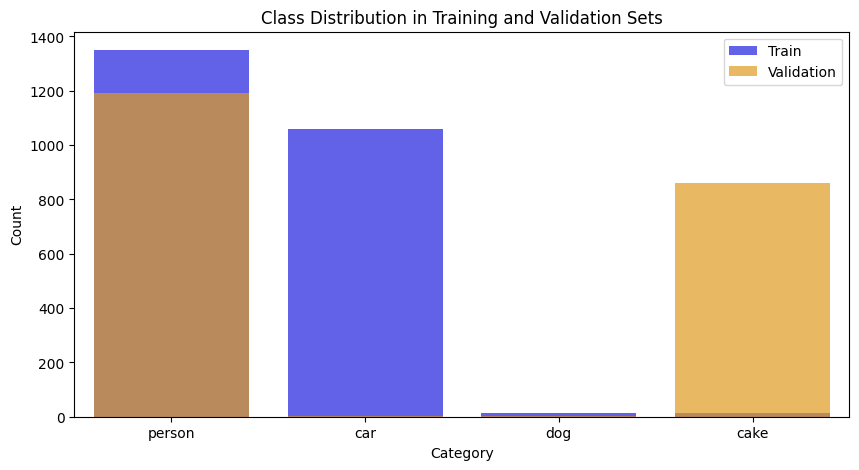

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extract category information
categories = {cat['id']: cat['name'] for cat in train_labels['categories']}

# Filter annotations for the relevant classes
relevant_categories = ["cake", "car", "dog", "person"]
relevant_category_ids = [k for k, v in categories.items() if v in relevant_categories]

# Count occurrences of each relevant category
train_counts = Counter(ann['category_id'] for ann in train_labels['annotations'] if ann['category_id'] in relevant_category_ids)
val_counts = Counter(ann['category_id'] for ann in val_labels['annotations'] if ann['category_id'] in relevant_category_ids)

# Visualization of class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=[categories[cid] for cid in train_counts.keys()], y=list(train_counts.values()), color='blue', alpha=0.7, label='Train')
sns.barplot(x=[categories[cid] for cid in val_counts.keys()], y=list(val_counts.values()), color='orange', alpha=0.7, label='Validation')
plt.title("Class Distribution in Training and Validation Sets")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend()
plt.show()



This code snippet utilizes the COCO API to analyze a custom image segmentation dataset. It loads annotations from JSON files located in Google Drive, specifically focusing on four target categories: "cake", "car", "dog", and "person".  The code first visualizes the class distribution in the training and validation sets using bar plots.  Then, using the `pycocotools.coco.COCO` class, it initializes COCO objects for both training and validation sets and retrieves the category IDs corresponding to the target categories for later use in the segmentation task.


In [ ]:
from pycocotools.coco import COCO
# Load the COCO annotations for training and validation sets
train_annotations_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/labels.json'
val_annotations_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/labels.json'

# Initialize COCO API for instance annotations
train_coco = COCO(train_annotations_path)
val_coco = COCO(val_annotations_path)

# Define the category IDs for 'cake', 'car', 'dog', and 'person'
target_categories = ["cake", "car", "dog", "person"]
category_ids = [cat['id'] for cat in train_coco.loadCats(train_coco.getCatIds()) if cat['name'] in target_categories]
print("Selected category IDs:", category_ids)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Selected category IDs: [15, 16, 25, 41]


In [ ]:
import cv2
import numpy as np
def visualize_segmentation(image_path, annotations, category_ids):
    image = cv2.imread(image_path)

    # Check if image was loaded correctly
    if image is None:
        print(f"Error: Unable to load image at path {image_path}")
        return

    for ann in annotations:
        if ann['category_id'] in category_ids:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

            for seg in ann['segmentation']:
                # Check that segmentation data is a list with an even number of elements
                if not isinstance(seg, list) or len(seg) < 6 or len(seg) % 2 != 0:
                    print(f"Skipping invalid segmentation data (not a valid polygon): {seg}")
                    continue

                try:
                    # Reshape into pairs of (x, y) coordinates
                    points = np.array(seg).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [points], color=255)
                except ValueError as e:
                    print(f"Error reshaping segmentation points: {seg} -> {e}")
                    continue

            # Define color based on category
            color = (0, 255, 0) if categories[ann['category_id']] == 'dog' else (255, 0, 0)
            image[mask > 0] = color

    # Show the final image with the overlayed segmentation masks
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


Skipping invalid segmentation data (not a valid polygon): counts
Skipping invalid segmentation data (not a valid polygon): size


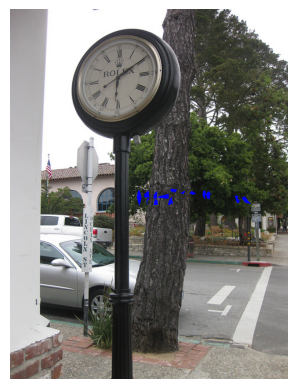

In [ ]:
# Verify sample image path and re-run visualization
sample_image_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data/000000000064.jpg'
if os.path.exists(sample_image_path):
    sample_annotations = [ann for ann in train_labels['annotations'] if ann['image_id'] == 1]
    visualize_segmentation(sample_image_path, sample_annotations, relevant_category_ids)
else:
    print(f"Error: The file {sample_image_path} does not exist.")

In [ ]:
dataset_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset'
dataDir='/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300'
dataType='train2017'
annFile='{}/labels.json'.format(dataDir,dataType)
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get category names
category_names = [cat['name'].title() for cat in cats]

# Get category counts
category_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
category_counts = [len(img_ids) for img_ids in category_counts]
ids = 1
cats = coco.loadCats(ids=ids)
print(cats)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
[{'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}]


[{'id': 15, 'name': 'cake', 'supercategory': 'food'}]
240
Annotations for Image ID 240:
/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data/
000000016254.jpg


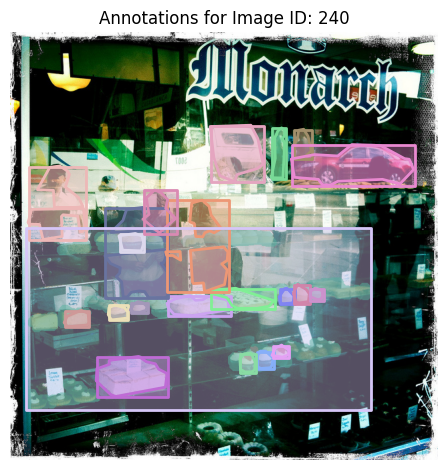

In [ ]:
catID = 15
print(coco.loadCats(ids=catID))

# Get image ids that satisfy the given filter conditions
imgId = coco.getImgIds(catIds=[catID])[0]
print(imgId)
ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

imageDir = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data/'
image_path = coco.loadImgs(imgId)[0]['file_name']
print(imageDir)
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(imgId))
plt.tight_layout()
plt.show()

# **PREPROCESSING**

Only keep annotations for the target classes by filtering the necessary classes.
Standardize image size to (512, 512).
Apply augmentations like rotation, flipping, etc., for better generalization.

In [ ]:
import albumentations as A

# Define augmentations
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

def preprocess_image(image, annotations):
    augmented = transform(image=image)
    image = augmented['image']
    # Mask transformations can also be applied if needed for annotations
    return image

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **MODEL TRAINING**

this training used a pre-trained segmentation model called Detectron2.

**Setting Up Mask R-CNN with Detectron2**

Detectron2 by Facebook AI Research is well-suited for segmentation tasks and supports Mask R-CNN.

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-202v_f6q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-202v_f6q
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9131ce0e5bc0c89904541bc0355d933ccd6acbfb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
import os
import json
from detectron2.structures import BoxMode

def get_coco_dataset_dicts(data_dir, labels):
    with open(labels) as f:
        coco_data = json.load(f)

    dataset_dicts = []
    category_mapping = {"cake": 1, "car": 2, "dog": 3, "person": 4}
    relevant_categories = ["cake", "car", "dog", "person"]
    cat_ids = [cat['id'] for cat in coco_data['categories'] if cat['name'] in relevant_categories]

    for img in coco_data['images']:
        record = {}
        img_id = img['id']

        record["file_name"] = os.path.join(data_dir, img['file_name'])
        record["image_id"] = img_id
        record["height"] = img['height']
        record["width"] = img['width']

        ann_ids = [ann['id'] for ann in coco_data['annotations'] if ann['image_id'] == img_id and ann['category_id'] in cat_ids]
        objs = []

        for ann_id in ann_ids:
            ann = next(ann for ann in coco_data['annotations'] if ann['id'] == ann_id)
            category_id = ann['category_id']

            if category_id not in cat_ids:
                continue

            # Handle segmentation format (polygon or RLE)
            segmentation = ann['segmentation']
            if isinstance(segmentation, dict) and "counts" in segmentation:
                # RLE format
                formatted_segmentation = segmentation
            elif isinstance(segmentation, list):
                if isinstance(segmentation[0], list):
                    # Polygon format with multiple contours
                    formatted_segmentation = segmentation
                else:
                    # Single polygon, wrap it in another list
                    formatted_segmentation = [segmentation]
            else:
                raise TypeError(f"Unexpected segmentation format in annotation {ann_id}: {segmentation}")

            obj = {
                "bbox": ann['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": formatted_segmentation,
                "category_id": cat_ids.index(category_id),
                "iscrowd": ann.get('iscrowd', 0)
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts


In [ ]:
# ipython-input-32-d08f004b803f
# Register the dataset
train_labels_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data/labels.json'
val_labels_path = '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/data/labels.json'

DatasetCatalog.register("cocotrains", lambda: get_coco_dataset_dicts('/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data', train_labels_path))
MetadataCatalog.get("cocotrains").set(thing_classes=relevant_categories)
DatasetCatalog.register("cocovals", lambda: get_coco_dataset_dicts('/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/validation-300/data', val_labels_path))
MetadataCatalog.get("cocovals").set(thing_classes=relevant_categories)

namespace(name='cocovals', thing_classes=['cake', 'car', 'dog', 'person'])

In [ ]:
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file

# Configuration
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # Use get_config_file to get the correct path
cfg.DATASETS.TRAIN = ("cocotrains",)
cfg.DATASETS.TEST = ("cocovals",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # Pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Only 4 classes: cake, car, dog, person

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/08 15:28:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[11/08 15:28:10 d2.engine.train_loop]: Starting training from iteration 0
[11/08 15:28:22 d2.utils.events]:  eta: 0:02:39  iter: 19  total_loss: 3.023  loss_cls: 1.663  loss_box_reg: 0.5309  loss_mask: 0.6911  loss_rpn_cls: 0.04596  loss_rpn_loc: 0.06039    time: 0.5724  last_time: 0.5965  data_time: 0.0194  last_data_time: 0.0104   lr: 6.427e-05  max_mem: 3180M
[11/08 15:28:33 d2.utils.events]:  eta: 0:02:27  iter: 39  total_loss: 2.258  loss_cls: 0.9321  loss_box_reg: 0.5002  loss_mask: 0.6704  loss_rpn_cls: 0.03154  loss_rpn_loc: 0.05152    time: 0.5732  last_time: 0.6178  data_time: 0.0092  last_data_time: 0.0038   lr: 0.00013087  max_mem: 3180M
[11/08 15:28:45 d2.utils.events]:  eta: 0:02:16  iter: 59  total_loss: 1.834  loss_cls: 0.5124  loss_box_reg: 0.5604  loss_mask: 0.6239  loss_rpn_cls: 0.03224  loss_rpn_loc: 0.06805    time: 0.5803  last_time: 0.6244  data_time: 0.0117  last_data_time: 0.0087   lr: 0.00019747  max_mem: 3180M
[11/08 15:28:57 d2.utils.events]:  eta: 0:02:07  

[11/08 15:39:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

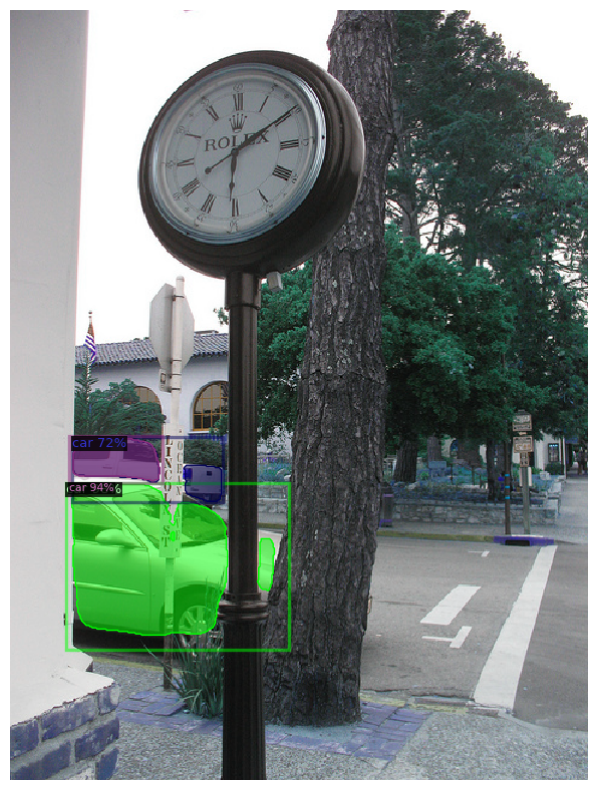

In [ ]:
# Set up the predictor for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for inference
predictor = DefaultPredictor(cfg)


test_image_paths = [
    '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/train-300/data/000000000064.jpg',]

# Visualize predictions
for test_img_path in test_image_paths:  # Define paths to test images
    im = cv2.imread(test_img_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("coco_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


# **TESTING ON THE FILTERED CLASSES**

[11/08 15:40:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

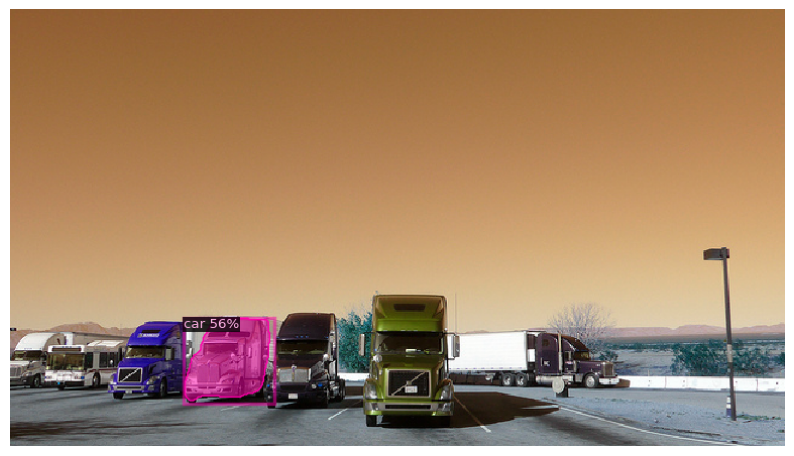

In [ ]:
# Set up the predictor for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for inference
predictor = DefaultPredictor(cfg)


test_image_paths = [
    '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/test-30/000000001494.jpg',]

# Visualize predictions
for test_img_path in test_image_paths:  # Define paths to test images
    im = cv2.imread(test_img_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("coco_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


[11/08 15:42:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

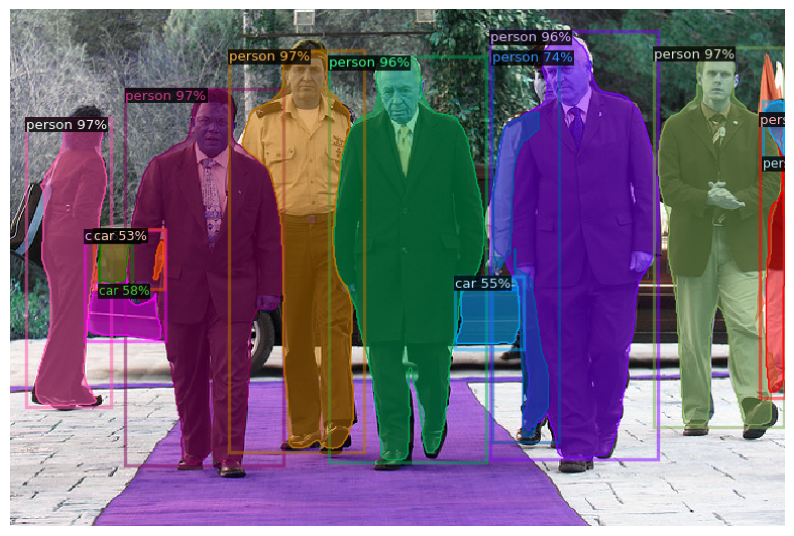

In [ ]:
# Set up the predictor for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for inference
predictor = DefaultPredictor(cfg)


test_image_paths = [
    '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/test-30/000000001551.jpg',]

# Visualize predictions
for test_img_path in test_image_paths:  # Define paths to test images
    im = cv2.imread(test_img_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("coco_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


[11/08 15:43:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

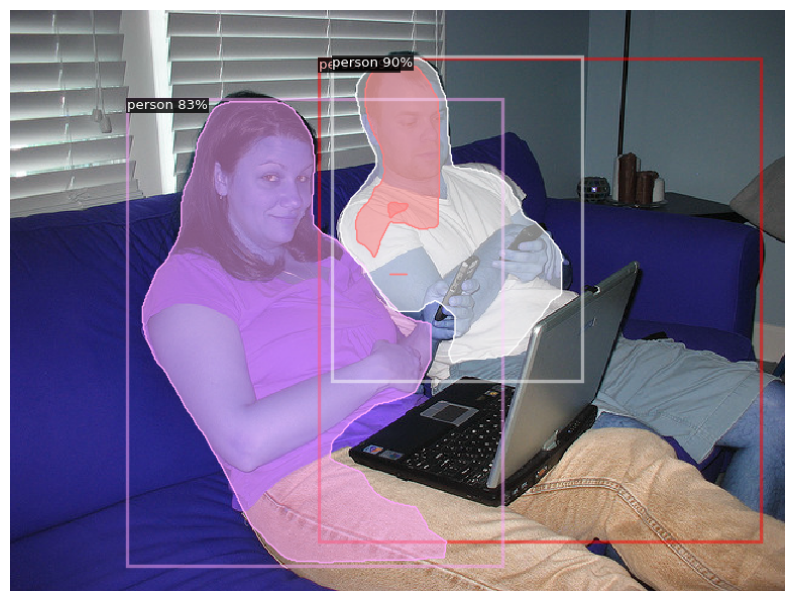

In [ ]:
# Set up the predictor for inference
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for inference
predictor = DefaultPredictor(cfg)


test_image_paths = [
    '/content/drive/MyDrive/RM_Segmentation_Assignment_dataset/test-30/000000001650.jpg',]

# Visualize predictions
for test_img_path in test_image_paths:  # Define paths to test images
    im = cv2.imread(test_img_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("coco_val"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
